# FVCOM UXARRAY Testing 

FVCOM is a bit finnicky because it is an unstructured grid. This makes using indexing methods and just loading it in general kind of a pain. The uxarray library exists for working with unstructured grids, and has some promises of eventually working with FVCOM, but it is not clear how far along it is in development.

Here is a light-weight attempt at accessing the data with uxarray, and subsetting depth dimensions. Something that curently is not possible with xarray.

### UPDATE: 3/25/2024 - UXARRAY Does not Support

In [2]:
# Libraries
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import os
from dateutil import parser
from datetime import datetime,timedelta
import uxarray as ux

# Set directory of where to save a manageable piece (relative path)
print(os.getcwd())

# Path to Box Assets
box_root = "/Users/akemberling/Library/CloudStorage/Box-Box/"
sf_root = f"{box_root}/RES_Data/Shapefiles"
lob_ecol_path = f"{box_root}/Mills Lab/Projects/Lobster ECOL"

/Users/akemberling/Documents/Repositories/Lobster-ECOL/py/FVCOM-prep


## Load NECOFS Data

I've done a lot with the gom3 hindcast, this seems like a good chance for practicing with the NECOFS gom4 output.

In [3]:
# Create a URL list that we can iterate through:
# hopefully it doesn't fail on us in the middle and ruin everything

# Start Year
start_yr = 2016

# End Year
end_yr = 2016

# Basic Structures for the year and month components
all_months = np.arange(1,13)
all_years  = np.arange(2016, 2023+1)

# Link base structure
base_url = "http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/"

# Generate all the URLs with a good old fashioned loop:
all_urls = []
for yr in all_years:
    yr_base = f"{base_url}{yr}/gom4_{yr}"
    
    for mon in all_months:
        yr_mon_ext = f"{yr_base}{mon:02d}.nc"
        all_urls.append(yr_mon_ext)


# Peak at the first few URLS
all_urls[0:2]

['http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201601.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201602.nc']

### Load a Day of NECOFS Data Xarray & as an unstructured grid with UXARRAY

In [50]:
# Load one day:
# Just need date and coords
ds = xr.open_dataset(
    f"{all_urls[0]}",
    decode_times = False)
ds

# convert lon/c, lat/c to coordinates
ds = ds.assign_coords({var:ds[var] for var in ['lon','lat','lonc','latc']})

# Fix time to see what the thirty years is:
# the first day
dt0 = parser.parse(ds.time.attrs['units'].replace('days since ',''))

# parse dates summing days to the origin
ds = ds.assign(time = [dt0 + timedelta(seconds = day * 86400) for day in ds.time.values])
ds

/Users/akemberling/opt/anaconda3/envs/fvcom_env/lib/python3.9/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.Dataset> Size: 96GB
Dimensions:        (nele: 99137, node: 53087, siglay: 40, siglev: 41, three: 3,
                    time: 744, maxnode: 11, maxelem: 9, four: 4)
Coordinates:
    x              (node) float32 212kB 1.7e+06 1.705e+06 ... 5.848e+05
    y              (node) float32 212kB 4.205e+05 4.149e+05 ... -1.28e+05
    lon            (node) float32 212kB ...
    lat            (node) float32 212kB ...
    lonc           (nele) float32 397kB ...
    latc           (nele) float32 397kB ...
    siglay         (siglay, node) float32 8MB ...
    siglev         (siglev, node) float32 9MB ...
  * time           (time) datetime64[ns] 6kB 2016-01-01 ... 2016-01-31T22:58:...
Dimensions without coordinates: nele, node, three, maxnode, maxelem, four
Data variables: (12/47)
    nprocs         int32 4B ...
    partition      (nele) int32 397kB ...
    xc             (nele) float32 397kB ...
    yc             (nele) float32 397kB ...
    h              (node) float32 212kB ...
    nv             (three, nele) int32 1MB ...
    ...             ...
    vwind_stress   (time, nele) float32 295MB ...
    icing_0kts     (time, node) float32 158MB ...
    icing_10kts    (time, node) float32 158MB ...
    icing_wndx     (time, node) float32 158MB ...
    icing_wndy     (time, node) float32 158MB ...
    icing_satmp    (time, node) float32 158MB ...
Attributes: (12/20)
    title:                           FVCOM GOM NECOFS HINDCAST UPDATE
    institution:                     School for Marine Science and Technology
    source:                          FVCOM_3.0
    history:                         Tue Mar 29 14:06:16 2016: ncrcat -d time...
    references:                      http://fvcom.smast.umassd.edu, http://co...
    Conventions:                     CF-1.0
    ...                              ...
    Icing_Model_Forcing:             FVCOM variable surface icing forcing:\nF...
    Special_Physical_processes:      long shore flow adjustment for thermal w...
    nco_openmp_thread_number:        1
    DODS.strlen:                     26
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  time

## Load Node/Element Indices for Subsetting:

If we know what mesh elements we want for each area from using the FVCOM R package, we might be able to pass these values in to ds.sel()

<Axes: >

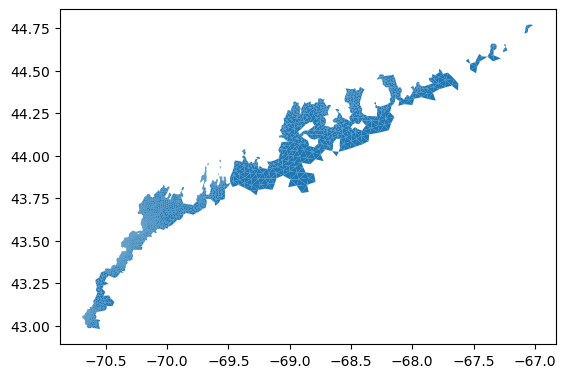

In [51]:
# Load the Inshore Area's  Mesh
vts_mesh = gpd.read_file(f"{lob_ecol_path}/FVCOM_support/VTSSurvey_FVCOM_nodes.geojson")
vts_mesh.plot()

In [52]:
# Drop geometry and get unique element and node
mesh_df = vts_mesh.drop(columns = "geometry")
mesh_df.head()

# Use unique function to get the node and element ID's
node_ids = pd.melt(mesh_df.drop(columns = ["elem"]))["value"].unique()
elem_ids = mesh_df["elem"].unique()

## Subsetting Variables for the Area of Interest - NOTE, node ID's don't match

Use the node ID's from the mesh, and use the first and last indices to subset surface and bottom measurements.

The node ID's that are generated from the fvcom package don't directly correspond to the lat/lon index orders.

In [56]:
# Subset the variables we care about
variables = [
    'temp',
    'salinity',
    'u', # Eastward Water Velocity
    'v'  # Northward Water Velocity
]

# Subset Check The nodes, elements
vts_trim = ds.isel(node = node_ids, nele = elem_ids)[variables]
vts_trim

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 744, siglay: 40, node: 2571, nele: 4178)
Coordinates:
    x         (node) float32 10kB 1.002e+06 9.969e+05 ... 8.528e+05 9.492e+05
    y         (node) float32 10kB 1.008e+05 1.052e+05 ... 2.81e+04 1.277e+05
    lon       (node) float32 10kB ...
    lat       (node) float32 10kB ...
    lonc      (nele) float32 17kB ...
    latc      (nele) float32 17kB ...
    siglay    (siglay, node) float32 411kB ...
  * time      (time) datetime64[ns] 6kB 2016-01-01 ... 2016-01-31T22:58:07.50...
Dimensions without coordinates: node, nele
Data variables:
    temp      (time, siglay, node) float32 306MB ...
    salinity  (time, siglay, node) float32 306MB ...
    u         (time, siglay, nele) float32 497MB ...
    v         (time, siglay, nele) float32 497MB ...
Attributes: (12/20)
    title:                           FVCOM GOM NECOFS HINDCAST UPDATE
    institution:                     School for Marine Science and Technology
    source:                          FVCOM_3.0
    history:                         Tue Mar 29 14:06:16 2016: ncrcat -d time...
    references:                      http://fvcom.smast.umassd.edu, http://co...
    Conventions:                     CF-1.0
    ...                              ...
    Icing_Model_Forcing:             FVCOM variable surface icing forcing:\nF...
    Special_Physical_processes:      long shore flow adjustment for thermal w...
    nco_openmp_thread_number:        1
    DODS.strlen:                     26
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
# check the contents:

ValueError: Cannot specify both x and y kwargs for line plots.

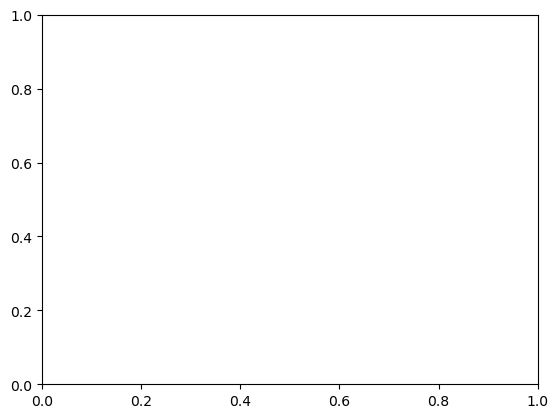

In [58]:
# Plot something
vts_trim.isel(time = 0, siglay = 0).temp.plot(x = "lon", y = "lat")